In [1]:
import os, math, json
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# init GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

Found GPU at: /device:GPU:0


In [3]:

baseDIR = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
for dirname, _, filenames in os.walk(baseDIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# Any results you write to the current directory are saved as output.

trainDir = baseDIR + 'train'
testDir = baseDIR + 'test'
validationDir = baseDIR + 'val'


/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1232-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0043-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA/person1612_virus_2797.jpeg


In [5]:
IMAGE_SIZE=[192,192]
BATCH_SIZE=64
EPOCHS=10

CLASSES=['bacteria','virus','normal']


validation_steps = 30
steps_per_epoch = 30


In [7]:
def plot_images(path, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if str.__contains__(file, '_'):
        plt.title(file.split('_')[1])
      else:
        plt.title('normal')
      imgplot = plt.imshow(img)

      amount += 1
        

### Pneumonia Image

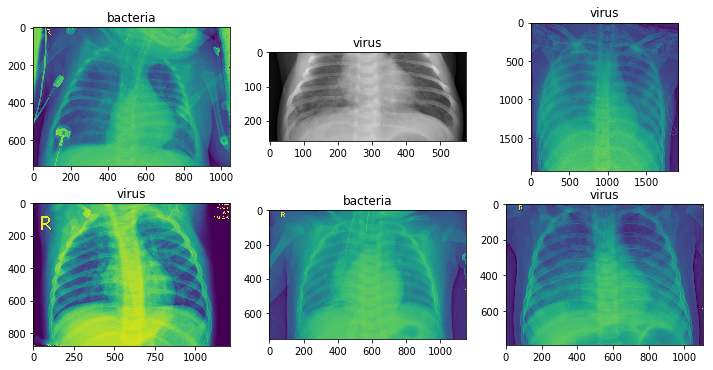

In [9]:
plot_images(trainDir+"/PNEUMONIA")

### normal Image

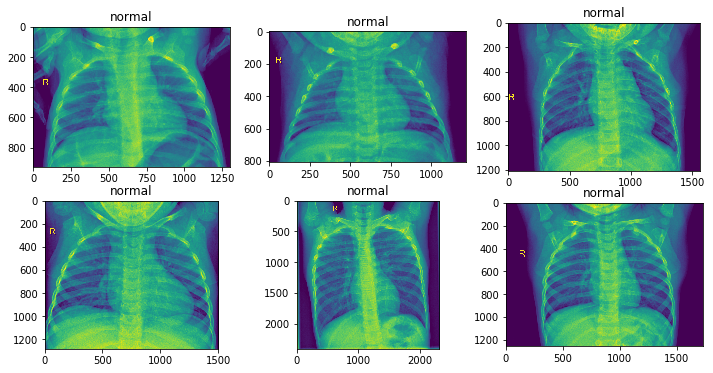

In [10]:
plot_images(trainDir +'/NORMAL')

In [12]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    trainDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validationDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    testDir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_96[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [15]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=5,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)
    )


Epoch 1/5
163/163 [==============================] - 105s 646ms/step - loss: 0.3780 - acc: 0.8635 - val_loss: 1.6216 - val_acc: 0.7500
Epoch 2/5
163/163 [==============================] - 81s 496ms/step - loss: 0.2693 - acc: 0.8947 - val_loss: 2.0128 - val_acc: 0.6875
Epoch 3/5
163/163 [==============================] - 81s 499ms/step - loss: 0.2502 - acc: 0.8997 - val_loss: 1.0593 - val_acc: 0.7500
Epoch 4/5
163/163 [==============================] - 81s 494ms/step - loss: 0.2447 - acc: 0.9026 - val_loss: 1.1404 - val_acc: 0.7500
Epoch 5/5
163/163 [==============================] - 78s 477ms/step - loss: 0.2511 - acc: 0.8993 - val_loss: 1.2913 - val_acc: 0.6875


In [17]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 13s 21ms/step
Loss: 1.2015171203567794
Accuracy: 0.6410256410256411


In [20]:
model.save('my_model.h5')
# new_model = keras.models.load_model('my_model.h5')